# This is mainly for testing new code and learning. 

The other one is where I am placing more refined and concrete results. 

In [37]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [48]:
ds = xr.open_dataset('../data/satellite/CMEMS_cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_2021-2024.nc')
ds['CHL']
CHL = ds['CHL']
CHL = CHL.sel({'longitude': slice(-45, -15), 'latitude': slice(45, 65)})
lon = CHL['longitude'].dims
lat = CHL['latitude'].dims
CHL

<xarray.DataArray 'CHL' (time: 1461, latitude: 480, longitude: 720)> Size: 2GB
[504921600 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 2kB 45.02 45.06 45.1 ... 64.9 64.94 64.98
  * longitude  (longitude) float32 3kB -44.98 -44.94 -44.9 ... -15.06 -15.02
  * time       (time) datetime64[ns] 12kB 2021-01-01 2021-01-02 ... 2024-12-31
Attributes:
    long_name:      Chlorophyll-a concentration - Mean of the binned pixels
    valid_max:      1000.0
    units:          milligram m-3
    valid_min:      0.0
    standard_name:  mass_concentration_of_chlorophyll_a_in_sea_water

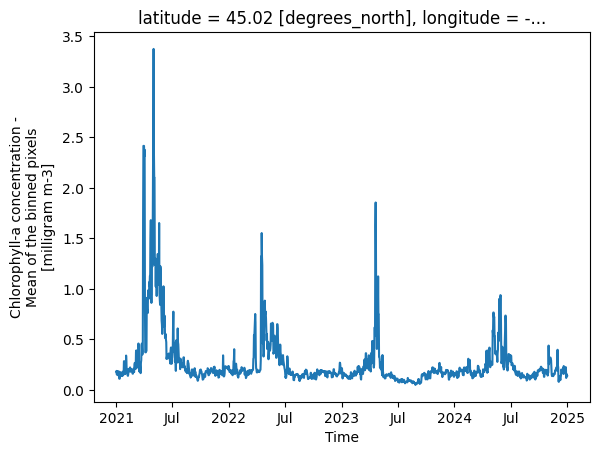

In [49]:
CHL_mon = CHL.resample(time = 'MS').mean()
CHL_clim12 = CHL_mon.groupby('time.month').mean('time')
CHL_annual_mean = CHL_clim12.mean('month')  
CHL.sel(latitude = -35, longitude = 50, method = 'nearest').plot.line()

TypeError: Dimensions of C (480, 720) should be one smaller than X(1) and Y(1) while using shading='flat' see help(pcolormesh)

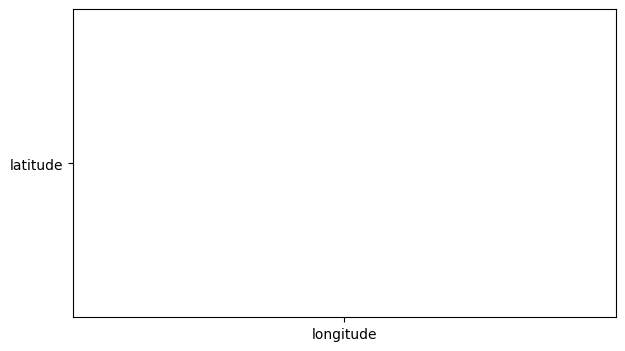

In [50]:
# Robust color scale for positive CHL values (log scale)
_vals = CHL_annual_mean.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolormesh(
    lon, lat, CHL_annual_mean.values,
    cmap='Greens', norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
    shading='auto'
)
plt.colorbar(cc, ax=ax, label='CHL (mg/m^-3)')
ax.set_title("CHL Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show()

# Coding a Mask/
Here I am going to try to extract data from a specific location (yet to be defined with purpose)

In [ ]:
LON, LAT = np.meshgrid(lon, lat)

In [ ]:
# 1) Ensure bathymetry uses the same lon/lat convention as CHL
# (you already converted bathy to -180..180 and masked land with z<=0)
# We’ll now interpolate bathy onto the CHL grid.
bathy_on_chl = bathy["z"].interp(
    longitude=CHL[lon_name],
    latitude=CHL[lat_name],
    method="linear",
)

CHL_deep_only = CHL.where(bathy_on_chl < -1500)
# 2) Build a boolean mask for "deep ocean" (deeper than -1500 m)
deep_mask = bathy_on_chl < -1500 

# 3) Drop CHL wherever it's deep (set to NaN where deep)
CHL_deep_only = CHL.where(~deep_mask)

# (Optional) If you *only* want the deep ocean, use:
# CHL_deep_only = CHL.where(deep_mask)

# 4) If you’re using your Shape1/Shape2 selections, apply the same mask
Shape1_CHL = CHL.where(Shape1).where(~deep_mask)
Shape2_CHL = CHL.where(Shape2).where(~deep_mask)

# 5) Quick visual sanity check
CHL_deep_only.isel(time=0).plot(
    x=lon_name, y=lat_name, robust=True
)
plt.title("CHL with deep ocean (z < -1500 m) filtered out")
plt.show()